In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 7137, done.
remote: Counting objects: 100% (580/580), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 7137 (delta 507), reused 503 (delta 442), pack-reused 6557
Receiving objects: 100% (7137/7137), 2.96 GiB | 25.60 MiB/s, done.
Resolving deltas: 100% (5874/5874), done.
Updating files: 100% (531/531), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 13.7 MB/s eta 0:00:00


In [3]:
! pip install implicit

  Obtaining dependency information for implicit from https://files.pythonhosted.org/packages/cd/cc/deac70cae8cc32c9885d0cd73bc66e1b3cbea36ae7080b8c83995eaf5322/implicit-0.7.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 37.9 MB/s eta 0:00:00


In [4]:
# ! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

In [5]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
import scipy.stats as stats
from concurrent.futures import ThreadPoolExecutor

from xgboost import XGBRanker

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv
/kaggle/input/training-tuned-models/als_all.npz
/kaggle/input/training-tuned-models/__results__.html
/kaggle/input/training-tuned-models/ease_r_all.zip
/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip
/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz
/kaggle/input/training-tuned-models/als_train_validation.npz
/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/slim_recall_train_validation.zip
/kaggle/input/training-tuned-models/ease_r_train_validation.zip
/kaggle/input/training-tuned-models/__notebook__.ipynb
/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/ials_train_validation.zip
/kaggle/input/training-tuned-models/mult_vae_2_all.zip
/kaggle/input/training-tuned-models/ease_r_xgbo

In [6]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [7]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender, SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender, ScaledPureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter
from Recommenders.MatrixFactorization.ALSImplicitRecommender import ALSImplicitRecommender
from Recommenders.GraphBased.HHPRecommender import HHPRecommender
from Recommenders.GraphBased.TwoWayRankAggregationRecommender import TwoWayRankAggregationRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [8]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [9]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [10]:
config = {
    'tune_parameters': True,
    'n_trials': 35,
    'database_path': '/kaggle/working/tuning_hybrid_xgboost.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': True,
    'save_github': True
}

In [11]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [12]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [13]:
URM_train_complete, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_complete, train_percentage = 0.8)

In [14]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_item.json', 'r') as params_file:
    params_item_knn = json.load(params_file)
params_item_knn

{'topK': 14,
 'shrink': 25,
 'similarity': 'tversky',
 'tversky_alpha': 0.18163095712123836,
 'tversky_beta': 1.8529812241698465}

In [15]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_RP3.json', 'r') as params_file:
    params_rp3 = json.load(params_file)
params_rp3

{'alpha': 0.3408516511081212, 'beta': 0.1447198697205665, 'topK': 32}

In [16]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_user.json', 'r') as params_file:
    params_user_knn = json.load(params_file)
params_user_knn

{'topK': 498,
 'shrink': 0,
 'similarity': 'asymmetric',
 'asymmetric_alpha': 0.39792525383867455}

In [17]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_alpha.json', 'r') as params_file:
    params_p3alpha = json.load(params_file)
params_p3alpha

{'normalize_similarity': 'True',
 'implicit': 'True',
 'alpha': 0.29354071531607107,
 'topK': 49}

In [18]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_merging.json', 'r') as params_file:
    params_merging = json.load(params_file)
params_merging

{'alpha': 0.3375591188839621, 'topK': 86}

In [19]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_lr_comb_rp3_p3a_item.json', 'r') as params_file:
    params_lr_comb = json.load(params_file)
params_lr_comb

{'w1': 0.6982294749234325, 'w2': 0.9336649353144076, 'w3': 0.8685182329823133}

In [20]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/pure_svd_params.json', 'r') as params_file:
    params_pure_svd = json.load(params_file)
params_pure_svd

{'factors': 30}

In [21]:
# with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_item.json', 'r') as params_file:
#     params_pure_svd_item = json.load(params_file)
params_pure_svd_item = {"topK": 43, "num_factors": 171}

In [22]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_scaled.json', 'r') as params_file:
    params_scaled = json.load(params_file)
params_scaled

{'num_factors': 179,
 'scaling_items': 5.3298425368534826e-05,
 'scaling_users': 0.2791990262721904}

In [23]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hhp.json', 'r') as params_file:
    params_hhp = json.load(params_file)
params_hhp

{'hybrid_lambda': 0.8450256587797654, 'topK': 61}

In [24]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_twra.json', 'r') as params_file:
    params = json.load(params_file)

params_twra = {
    'base_f_algorithm': params['base_f_algorithm'], 
    'base_b_algorithm': params['base_b_algorithm'], 
    'convex_lambda': params['convex_lambda'],
}

if params['base_f_algorithm'] == 'p3':
    params_twra['f_params'] = {
        'topK': params['f_p3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_f_algorithm'] == 'p3alpha':
    params_twra['f_params'] = {
        'alpha': params['f_p3a_alpha'],
        'topK': params['f_p3a_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_f_algorithm'] == 'rp3beta':
    params_twra['f_params'] = {
        'alpha': params['f_rp3_alpha'],
        'beta': params['f_rp3_beta'],
        'topK': params['f_rp3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
else:
    params_twra['f_params'] = {
        'hybrid_lambda': params['f_hhp_hybrid_lambda'],
        'topK': params['f_hhp_topK'],
    }

if params['base_b_algorithm'] == 'p3':
    params_twra['b_params'] = {
        'topK': params['b_p3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_b_algorithm'] == 'p3alpha':
    params_twra['b_params'] = {
        'alpha': params['b_p3a_alpha'],
        'topK': params['b_p3a_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_b_algorithm'] == 'rp3beta':
    params_twra['b_params'] = {
        'alpha': params['b_rp3_alpha'],
        'beta': params['b_rp3_beta'],
        'topK': params['b_rp3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
else:
    params_twra['b_params'] = {
        'hybrid_lambda': params['b_hhp_hybrid_lambda'],
        'topK': params['b_hhp_topK'],
    }

In [25]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_rp3_recall@50.json', 'r') as params_file:
    params_rp3_recall = json.load(params_file)
params_rp3_recall

{'alpha': 0.2139985499567939, 'beta': 0.2194371742883361, 'topK': 154}

In [26]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_item_knn_recall@50.json', 'r') as params_file:
    params_item_knn_recall = json.load(params_file)
params_item_knn_recall

{'topK': 62,
 'shrink': 480,
 'similarity': 'tversky',
 'feature_weighting': 'BM25',
 'tversky_alpha': 0.03679620043176055,
 'tversky_beta': 1.9314395554791928}

In [27]:
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip', 
    '/kaggle/working/ials_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_train_validation.zip', 
    '/kaggle/working/ials_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_all.zip', 
    '/kaggle/working/ials_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz', 
    '/kaggle/working/als_xgboost_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_train_validation.npz', 
    '/kaggle/working/als_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_all.npz', 
    '/kaggle/working/als_all.npz', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_xgboost_train_validation.zip', 
    '/kaggle/working/slim_recall_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_train_validation.zip', 
    '/kaggle/working/slim_recall_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_all.zip', 
    '/kaggle/working/slim_recall_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip', 
    '/kaggle/working/mult_vae_2_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip', 
    '/kaggle/working/mult_vae_2_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_all.zip', 
    '/kaggle/working/mult_vae_2_all.zip', 
)

'/kaggle/working/mult_vae_2_all.zip'

In [28]:
recommender_item = ItemKNNCFRecommender(URM_train)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_train = recommender_pure_svd.USER_factors
item_factors_train = recommender_pure_svd.ITEM_factors

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_xgboost_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_xgboost_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_xgboost_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_xgboost_train_validation.zip')

recommender_ials = IALSRecommender(URM_train)
recommender_ials.load_model('/kaggle/working/', 'ials_xgboost_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_xgboost_train_validation')

recommender_hhp = HHPRecommender(URM_train)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train)
# recommender_als.load_model('/kaggle/working/', 'als_xgboost_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_xgboost_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train)
recommender_item_recall.fit(**params_item_knn_recall)

ItemKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1207.19 column/sec. Elapsed time 18.51 sec
UserKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 757.64 column/sec. Elapsed time 17.19 sec
RP3betaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
RP3betaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2734.02 column/sec. Elapsed time 8.17 sec
P3alphaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
P3alphaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
P3alphaRecommender: Similarity colu

In [29]:
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions


In [30]:
cutoff = 50
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    if user_id == 0:
        print(recommendations)
    training_dataframe.loc[user_id, "ItemID"] = recommendations
    
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

/tmp/ipykernel_19/2461008040.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

[   0    1    2    3    9   28   35   53   57   75   76   84   86   97
  100  101  111  122  136  138  155  170  215  253  256  260  283  288
  336  341  366  402  428  429  505  514  533  591  617  634  636  693
  715  772  849  868  921  976 1056 1067 1082 1088 1131 1213 1222 1287
 1337 1421 1480 1489 1515 1545 1629 1744 1934 2002 2011 2498 2667 2781
 3156 3315 3728 6222 8455 8500]


,ItemID
UserID,
0,0
0,1
0,2
0,3
0,9
...,...
13023,11653
13023,11827
13023,11955


In [31]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,15
1,0,385
2,0,1934
3,0,4302
4,0,17444
...,...,...
76592,13023,2365
76593,13023,2961
76594,13023,3606
76595,13023,6282


In [32]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,0,False
1,0,1,False
2,0,2,False
3,0,3,False
4,0,9,False
...,...,...,...
1067049,13023,11653,False
1067050,13023,11827,False
1067051,13023,11955,False
1067052,13023,13592,False


In [33]:
training_dataframe.Label.sum()

19947

In [34]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
#     'NMF': recommender_nmf,
#     'PureSVD': recommender_pure_svd,
#     'ScaledSVD': recommender_scaled_svd,
#     'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
#     'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [35]:
tmp = training_dataframe[training_dataframe['UserID'] == 0].copy()

scores = recommender_item._compute_item_score([0])
linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
linf_scores[0, :] = recommender_item._remove_seen_on_scores(0, linf_scores[0, :])
linf_scores

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [36]:
rank = np.argsort(linf_scores[0, :])[::-1]
rank[:50]

array([  35,  100,  505,  591,  693, 1480,  402,  617,  341,  122, 1421,
       1545,  428, 1082, 1287, 1337, 1213, 1088,  170,  138,  253, 1131,
       3156, 1056,  215, 3728,  514,  101, 2724, 1629,  485, 1913, 1257,
        772,   75, 4499,  385, 2539,  492,  636, 4749, 1934, 2480,  849,
       1813,  155, 2002, 1514,  976,  699])

In [37]:
tmp.ItemID.values.astype(int)

array([   0,    1,    2,    3,    9,   28,   35,   53,   57,   75,   76,
         84,   86,   97,  100,  101,  111,  122,  136,  138,  155,  170,
        215,  253,  256,  260,  283,  288,  336,  341,  366,  402,  428,
        429,  505,  514,  533,  591,  617,  634,  636,  693,  715,  772,
        849,  868,  921,  976, 1056, 1067, 1082, 1088, 1131, 1213, 1222,
       1287, 1337, 1421, 1480, 1489, 1515, 1545, 1629, 1744, 1934, 2002,
       2011, 2498, 2667, 2781, 3156, 3315, 3728, 6222, 8455, 8500])

In [38]:
item_list = tmp.ItemID.values.astype(int)

positions = np.zeros(n_items, dtype=int)
positions[rank] = np.arange(n_items)
positions[item_list]

array([21981,  7491,  7492,  7493,  7498,  7473,     0,  7540,  7544,
          34,  7519,  7527,  7529,  7410,     1,    27,    50,     9,
        7423,    19,    45,    18,    24,    20,  7687,  7691,  7584,
        7589,  7637,     8,  7146,     6,    12,  7187,     2,    26,
        7087,     3,     7,  7294,    39,     4,  7261,    33,    43,
        8148,    60,    48,    23,  8297,    13,    17,    21,    16,
        7795,    14,    15,    10,     5,  6152,  6134,    11,    29,
          66,    41,    46,  5951,  6456,  6405,    58,    22,    67,
          25,    62,    56,  4623])

In [39]:
recommended = np.isin(item_list, rank[:10], assume_unique=True)
recommended.astype(int)

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [40]:
training_dataframe = training_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        training_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        training_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        training_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()

item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

# todo: cluster if possible the similarity matrix of KNN or RP3, then add for each users some features 
# that represent something like users that like only items from the same cluster (e.g. items variability)
# same can be done with users and items reversed (i.e. using User KNN)

recommended_columns = [col for col in training_dataframe.columns if col.endswith('_Recommended')]
training_dataframe['Counter_Recommended'] = training_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in training_dataframe.columns if col.endswith('_RankPosition')]
training_dataframe['Mean_RankPosition'] = training_dataframe[position_columns].mean(axis=1)
training_dataframe['Std_RankPosition'] = training_dataframe[position_columns].std(axis=1)
training_dataframe['Skew_RankPosition'] = training_dataframe[position_columns].skew(axis=1)
training_dataframe['Kurtosis_RankPosition'] = training_dataframe[position_columns].kurtosis(axis=1)

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_19/223847650.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
/tmp/ipykernel_19/223847650.py:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,MaxSimilarityToSeenRP3,MinSimilarityToSeenRP3,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition
0,0,0,False,0.000000,21981.0,0.0,0.046025,50.0,0.0,0.172726,...,0.000000,0.0,0.000000,NaN,NaN,0,2239.6,6936.502820,3.162138,9.999350
1,0,1,False,0.000000,7491.0,0.0,0.045999,51.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,0,3600.8,4656.295471,0.854885,-0.806174
2,0,2,False,0.000000,7492.0,0.0,0.102911,4.0,1.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,2,4276.5,4688.592569,0.402352,-1.434449
3,0,3,False,0.000000,7493.0,0.0,0.071723,12.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,0,4121.5,4411.369005,0.207081,-2.031058
4,0,9,False,0.000000,7498.0,0.0,0.094539,5.0,1.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,1,3040.2,3866.053423,0.484167,-2.275425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067049,13023,11653,False,0.176484,17.0,0.0,0.124148,146.0,0.0,0.176945,...,0.065990,0.0,0.011571,4.329403,18.561111,0,51.8,47.210639,1.103116,-0.011741
1067050,13023,11827,False,0.000000,18388.0,0.0,0.102497,217.0,0.0,0.000000,...,0.024023,0.0,0.003503,6.559135,41.022263,0,7623.6,9464.455331,0.486172,-2.265245
1067051,13023,11955,False,0.092565,54.0,0.0,0.111171,184.0,0.0,0.077925,...,0.040833,0.0,0.008920,3.700808,12.059912,0,166.3,140.777247,1.548970,1.754631
1067052,13023,13592,False,0.295934,5.0,1.0,0.102905,214.0,0.0,0.233513,...,0.080118,0.0,0.016885,2.835449,7.682983,5,57.0,79.476062,1.379683,0.384955


In [41]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
item_popularity = item_popularity / np.max(item_popularity)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
user_popularity = user_popularity / np.max(user_popularity)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
training_dataframe['mainstream_user'] = mainstream_user[training_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
training_dataframe['mainstream_item'] = mainstream_item[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len,mainstream_user,mainstream_item
0,0,0,False,0.000000,21981.0,0.0,0.046025,50.0,0.0,0.172726,...,NaN,0,2239.6,6936.502820,3.162138,9.999350,0.886424,0.033573,77.384713,64.370937
1,0,1,False,0.000000,7491.0,0.0,0.045999,51.0,0.0,0.000000,...,NaN,0,3600.8,4656.295471,0.854885,-0.806174,1.000000,0.033573,77.384713,62.304556
2,0,2,False,0.000000,7492.0,0.0,0.102911,4.0,1.0,0.000000,...,NaN,2,4276.5,4688.592569,0.402352,-1.434449,0.816327,0.033573,77.384713,66.387950
3,0,3,False,0.000000,7493.0,0.0,0.071723,12.0,0.0,0.000000,...,NaN,0,4121.5,4411.369005,0.207081,-2.031058,0.988465,0.033573,77.384713,68.811732
4,0,9,False,0.000000,7498.0,0.0,0.094539,5.0,1.0,0.000000,...,NaN,1,3040.2,3866.053423,0.484167,-2.275425,0.507542,0.033573,77.384713,58.666614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067049,13023,11653,False,0.176484,17.0,0.0,0.124148,146.0,0.0,0.176945,...,18.561111,0,51.8,47.210639,1.103116,-0.011741,0.007986,0.055156,53.265190,302.245004
1067050,13023,11827,False,0.000000,18388.0,0.0,0.102497,217.0,0.0,0.000000,...,41.022263,0,7623.6,9464.455331,0.486172,-2.265245,0.006211,0.055156,53.265190,326.633094
1067051,13023,11955,False,0.092565,54.0,0.0,0.111171,184.0,0.0,0.077925,...,12.059912,0,166.3,140.777247,1.548970,1.754631,0.005324,0.055156,53.265190,211.481415
1067052,13023,13592,False,0.295934,5.0,1.0,0.102905,214.0,0.0,0.233513,...,7.682983,5,57.0,79.476062,1.379683,0.384955,0.004437,0.055156,53.265190,296.209113


In [42]:
user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])

training_dataframe = training_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
training_dataframe = training_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
training_dataframe = training_dataframe.sort_values(by='UserID')
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,False,0.000000,21981.0,0.0,0.046025,50.0,0.0,0.172726,...,0.163921,0.090707,-0.216788,-0.041741,0.056197,0.005684,-0.001896,0.008995,-0.013853,-0.002147
54,0,1222,False,0.000000,7795.0,0.0,0.019094,355.0,0.0,0.000000,...,0.008628,0.004001,0.018486,-0.012392,0.001480,0.005684,-0.001896,0.008995,-0.013853,-0.002147
53,0,1213,False,0.215692,16.0,0.0,0.026164,201.0,0.0,0.119938,...,0.007796,-0.009614,0.002953,-0.000483,-0.004862,0.005684,-0.001896,0.008995,-0.013853,-0.002147
52,0,1131,False,0.170961,21.0,0.0,0.018603,372.0,0.0,0.079453,...,0.008328,-0.008771,0.024645,0.012543,0.037796,0.005684,-0.001896,0.008995,-0.013853,-0.002147
51,0,1088,False,0.211910,17.0,0.0,0.009479,1086.0,0.0,0.095478,...,0.011467,-0.011217,0.021460,0.020043,0.052159,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067010,13023,695,False,0.051093,114.0,0.0,0.344100,10.0,0.0,0.000000,...,0.011910,-0.020622,0.017123,0.012590,0.042566,0.006896,-0.007143,0.001571,0.006195,0.023549
1067008,13023,605,True,0.057563,100.0,0.0,0.203670,56.0,0.0,0.061681,...,0.016095,-0.028862,0.009837,0.013453,0.047040,0.006896,-0.007143,0.001571,0.006195,0.023549
1067005,13023,407,False,0.000000,7195.0,0.0,0.277303,23.0,0.0,0.000000,...,0.019528,-0.040613,0.013791,0.005590,0.052483,0.006896,-0.007143,0.001571,0.006195,0.023549
1067016,13023,1068,False,0.158385,18.0,0.0,0.194655,65.0,0.0,0.145328,...,0.010152,-0.018598,0.011308,0.011311,0.036143,0.006896,-0.007143,0.001571,0.006195,0.023549


In [43]:
n_estimators = 500
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 32
grow_policy = "depthwise"
objective = "map"  #"pairwise", "ndcg"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(
    objective='rank:{}'.format(objective),
    n_estimators = int(n_estimators),
    random_state = random_seed,
    learning_rate = learning_rate,
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,
    max_depth = int(max_depth),
    max_leaves = int(max_leaves),
    grow_policy = grow_policy,
    verbosity = 1,
    booster = booster,
    enable_categorical = True
)

In [44]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([76, 71, 77, ..., 92, 73, 69])

In [45]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])
X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")
# X_train["UserID"] = X_train["UserID"].astype(int)
# X_train["ItemID"] = X_train["ItemID"].astype(int)

# object_columns = X_train.select_dtypes(include=['object']).columns
# X_train[object_columns] = X_train[object_columns].astype('category')

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=32, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=500,
          n_jobs=None, num_parallel_tree=None, objective='rank:map', ...)

<Axes: title={'center': 'Feature Importance (Weight)'}, xlabel='F score', ylabel='Features'>

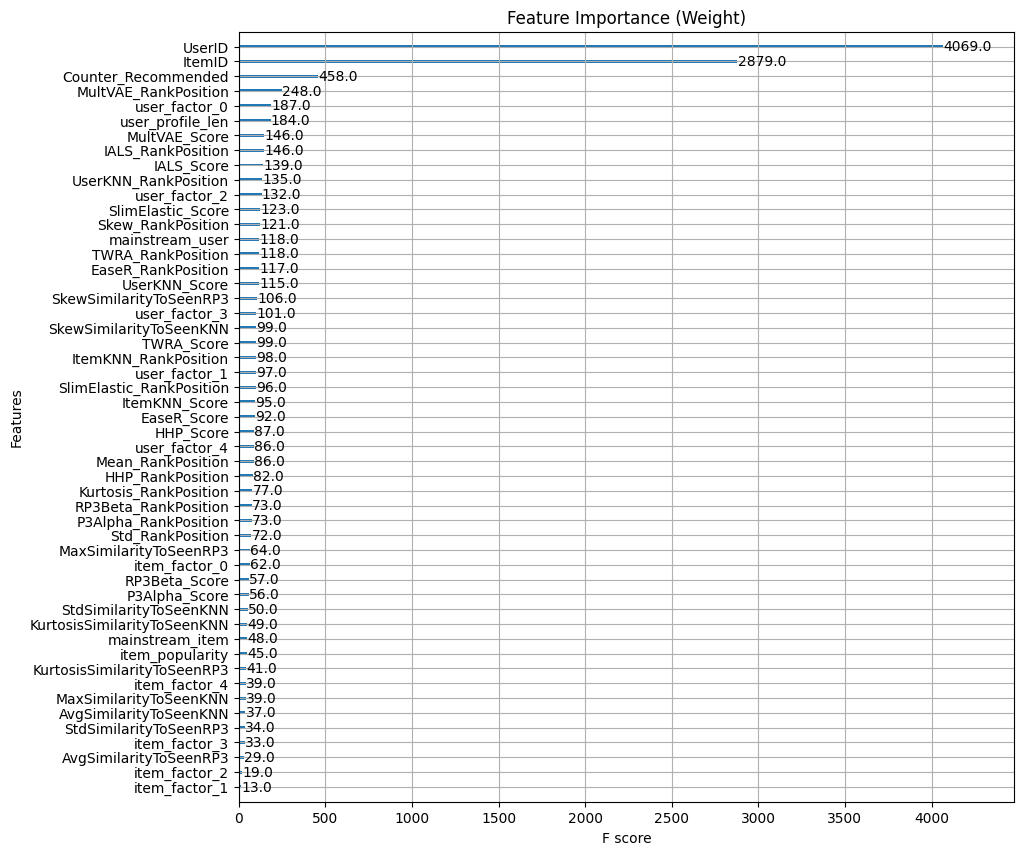

In [46]:
from xgboost import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='weight', title='Feature Importance (Weight)', ax=ax)

<Axes: title={'center': 'Feature Importance (Cover)'}, xlabel='F score', ylabel='Features'>

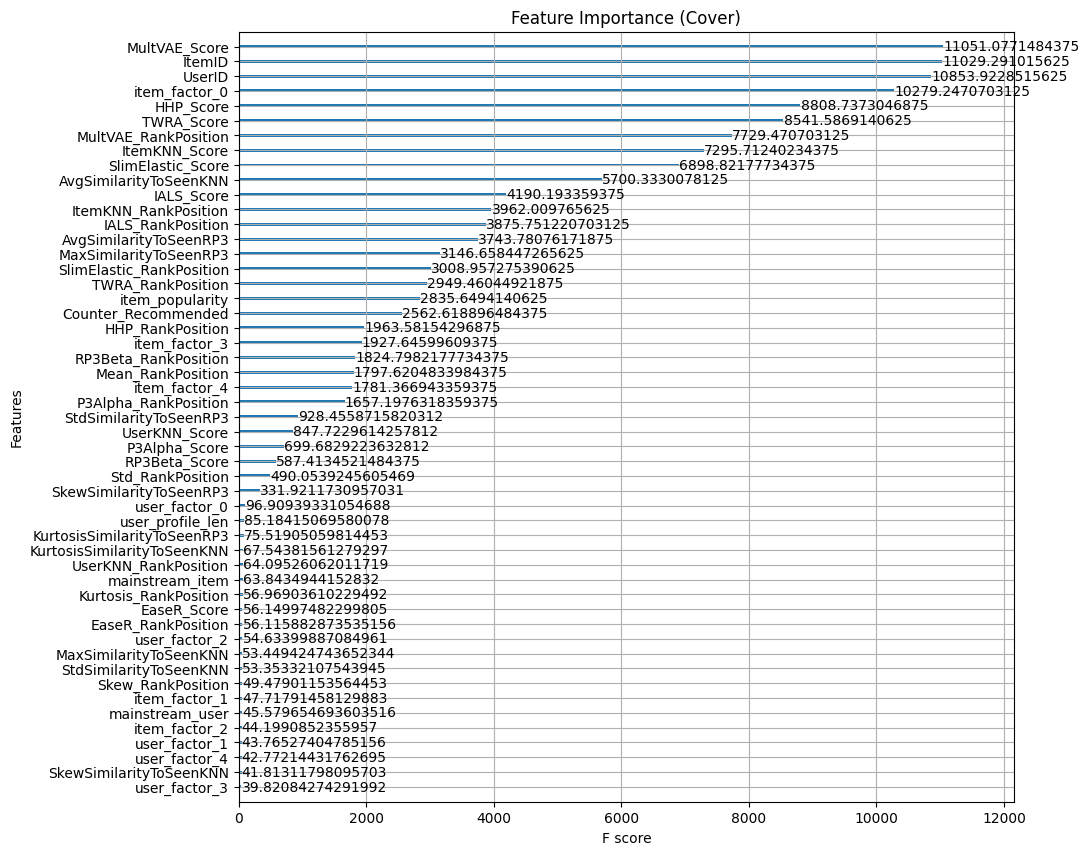

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='cover', title='Feature Importance (Cover)', ax=ax)

<Axes: title={'center': 'Feature Importance (Gain)'}, xlabel='F score', ylabel='Features'>

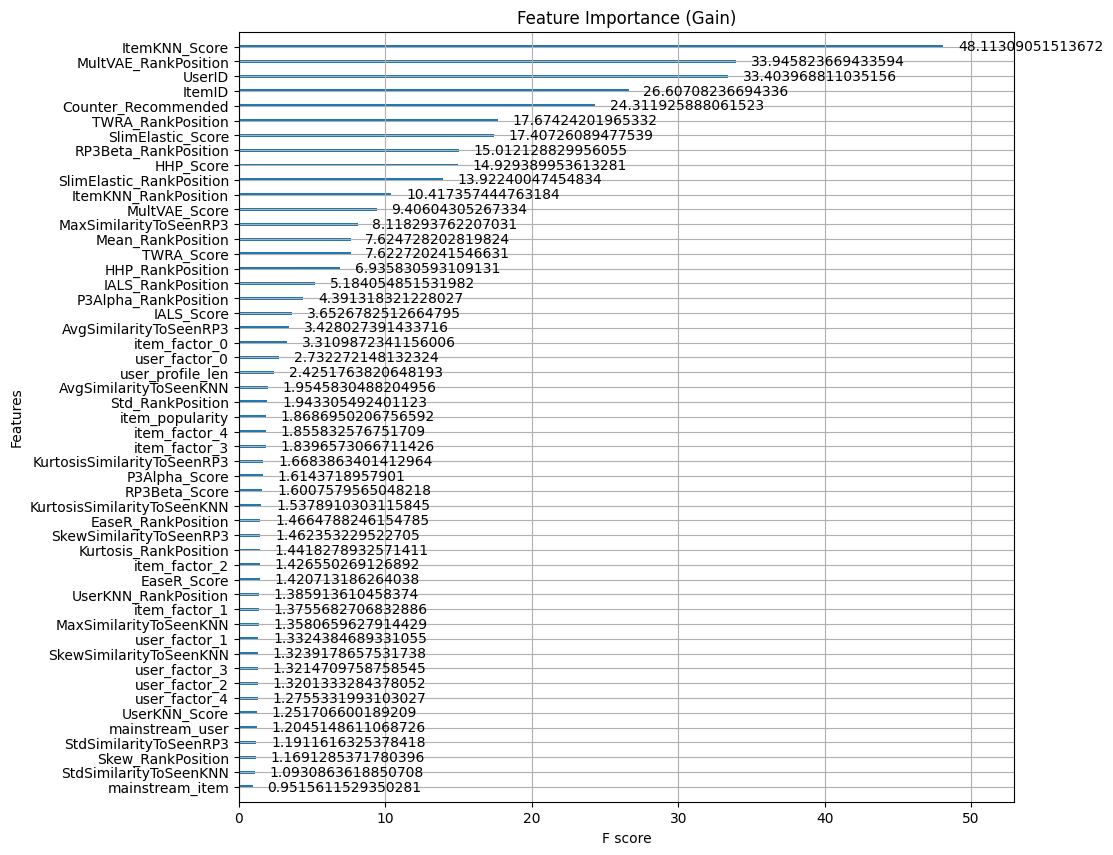

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='gain', title='Feature Importance (Gain)', ax=ax)

In [49]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

recommender_hhp = HHPRecommender(URM_train_complete)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train_complete)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train_complete)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train_complete)
recommender_item_recall.fit(**params_item_knn_recall)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1050.99 column/sec. Elapsed time 21.26 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 711.10 column/sec. Elapsed time 18.32 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2593.15 column/sec. Elapsed time 8.62 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity colu

In [50]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
#     'NMF': recommender_nmf,
#     'PureSVD': recommender_pure_svd,
#     'ScaledSVD': recommender_scaled_svd,
#     'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
#     'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [51]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

validation_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
validation_dataframe.index.name='UserID'

for user_id in tqdm.auto.tqdm(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    validation_dataframe.loc[user_id, "ItemID"] = recommendations
    
validation_dataframe = validation_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = validation_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        validation_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        validation_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        validation_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()
    
validation_dataframe = validation_dataframe.reset_index()
validation_dataframe = validation_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in validation_dataframe.columns if col.endswith('_Recommended')]
validation_dataframe['Counter_Recommended'] = validation_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in validation_dataframe.columns if col.endswith('_RankPosition')]
validation_dataframe['Mean_RankPosition'] = validation_dataframe[position_columns].mean(axis=1)
validation_dataframe['Std_RankPosition'] = validation_dataframe[position_columns].std(axis=1)
validation_dataframe['Skew_RankPosition'] = validation_dataframe[position_columns].skew(axis=1)
validation_dataframe['Kurtosis_RankPosition'] = validation_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
validation_dataframe['item_popularity'] = item_popularity[validation_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
validation_dataframe['user_profile_len'] = user_popularity[validation_dataframe["UserID"].values.astype(int)]
validation_dataframe

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len
0,0,0,0.000000,22282.0,0.0,0.049929,89.0,0.0,0.000000,22283.0,...,0.000000,NaN,NaN,0,6725.0,10726.657696,1.035071,-1.224485,0.886121,0.032075
1,0,1,0.000000,7496.0,0.0,0.090336,15.0,0.0,0.000000,7477.0,...,0.000000,NaN,NaN,0,3082.9,3821.952190,0.482605,-2.274253,1.000000,0.032075
2,0,2,0.000000,7497.0,0.0,0.095367,13.0,0.0,0.000000,7478.0,...,0.000000,NaN,NaN,0,3947.6,4136.405665,0.051490,-2.451839,0.811388,0.032075
3,0,3,0.000000,7498.0,0.0,0.114379,6.0,1.0,0.000000,7479.0,...,0.000000,NaN,NaN,1,4102.6,4378.702832,0.187281,-2.088190,0.973665,0.032075
4,0,7,0.189751,24.0,0.0,0.075345,28.0,0.0,0.113997,12.0,...,0.000000,NaN,NaN,0,27.4,12.438292,0.711533,-0.123813,0.692527,0.032075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055431,13023,10912,0.124691,41.0,0.0,0.077127,408.0,0.0,0.030217,154.0,...,0.011540,2.528026,4.419128,0,335.9,601.219215,2.943190,8.925155,0.004982,0.056604
1055432,13023,11018,0.149842,35.0,0.0,0.163464,120.0,0.0,0.147351,30.0,...,0.011594,2.325696,3.618560,0,44.3,29.981661,2.130106,4.799780,0.004982,0.056604
1055433,13023,11653,0.248895,16.0,0.0,0.164520,118.0,0.0,0.305779,12.0,...,0.013050,3.435117,10.790638,2,29.0,33.947672,2.433853,6.126671,0.007117,0.056604
1055434,13023,11955,0.260745,15.0,0.0,0.157063,126.0,0.0,0.138857,32.0,...,0.014879,2.872438,6.805297,0,40.6,33.483661,2.172849,5.169136,0.004982,0.056604


In [52]:
mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
validation_dataframe['mainstream_user'] = mainstream_user[validation_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
validation_dataframe['mainstream_item'] = mainstream_item[validation_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])
validation_dataframe = validation_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
validation_dataframe = validation_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
validation_dataframe = validation_dataframe.sort_values(by='UserID')

validation_dataframe

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,0.000000,22282.0,0.0,0.049929,89.0,0.0,0.000000,22283.0,...,0.163921,0.090707,-0.216788,-0.041741,0.056197,0.005684,-0.001896,0.008995,-0.013853,-0.002147
60,0,1257,0.113153,50.0,0.0,0.021715,426.0,0.0,0.055753,56.0,...,0.009264,0.007807,0.009192,0.015810,0.004970,0.005684,-0.001896,0.008995,-0.013853,-0.002147
59,0,1213,0.219015,17.0,0.0,0.035522,166.0,0.0,0.086829,25.0,...,0.007796,-0.009614,0.002953,-0.000483,-0.004862,0.005684,-0.001896,0.008995,-0.013853,-0.002147
58,0,1088,0.206087,20.0,0.0,0.000000,9824.0,0.0,0.063827,43.0,...,0.011467,-0.011217,0.021460,0.020043,0.052159,0.005684,-0.001896,0.008995,-0.013853,-0.002147
57,0,1082,0.261194,14.0,0.0,0.031374,224.0,0.0,0.101984,16.0,...,0.008902,-0.013901,0.005310,0.008307,0.003830,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055413,13023,2152,0.000000,5870.0,0.0,0.216950,65.0,0.0,0.000000,5857.0,...,0.004974,-0.014541,0.004915,0.004194,0.023232,0.006896,-0.007143,0.001571,0.006195,0.023549
1055412,13023,2119,0.487735,5.0,1.0,0.364687,11.0,0.0,0.439395,7.0,...,0.003394,-0.009902,0.004116,0.002884,0.015884,0.006896,-0.007143,0.001571,0.006195,0.023549
1055414,13023,2195,0.296294,11.0,0.0,0.290332,27.0,0.0,0.251844,15.0,...,0.004869,-0.011313,0.006562,-0.000144,0.018232,0.006896,-0.007143,0.001571,0.006195,0.023549
1055410,13023,1791,0.034666,147.0,0.0,0.248859,40.0,0.0,0.050318,88.0,...,0.006689,-0.014163,0.015855,0.009517,0.029980,0.006896,-0.007143,0.001571,0.006195,0.023549


In [53]:
validation_dataframe["UserID"] = validation_dataframe["UserID"].astype("category")
validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype("category")

# validation_dataframe["UserID"] = validation_dataframe["UserID"].astype(int)
# validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype(int)

# object_columns = validation_dataframe.select_dtypes(include=['object']).columns
# validation_dataframe[object_columns] = validation_dataframe[object_columns].astype('category')

In [54]:
class XGBoostRerankerRecommender:
    def __init__(self, URM_train, XGB_model, df):
        self.URM_train = URM_train
        self.df = df
        self.XGB_model = XGB_model
        
    def recommend(self, user_ids, cutoff=10, return_scores=True, remove_seen_flag=True, remove_top_pop_flag=True, remove_custom_items_flag=False):
        recommendations = []
        for user_id in user_ids:
            df_slice = self.df[self.df['UserID'] == user_id]
            items = df_slice.ItemID.to_numpy()
            preds = self.XGB_model.predict(df_slice)
            recommendations.append(items[np.argsort(preds)[-cutoff:][::-1]].tolist())
            
        if return_scores:
            rec, scores = recommender_item.recommend(user_ids, cutoff=cutoff, return_scores=return_scores)
            # useless scores
            return np.array(recommendations), scores
        return np.array(recommendations)
    
    def get_URM_train(self):
        return self.URM_train

In [55]:
recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
result_df, _ = evaluator.evaluateRecommender(recommender)
result_df

EvaluatorHoldout: Processed 10456 (100.0%) in 4.17 min. Users per second: 42


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.090388,0.159098,0.134581,0.043614,0.074569,0.243377,0.138735,0.108144,0.506217,0.322471,...,0.802826,0.406404,0.802826,0.042388,9.680282,0.996171,0.122306,0.745731,2.244269,0.287723


In [56]:
def objective_xgboost(trial):

    XGB_model = XGBRanker(
        objective = trial.suggest_categorical('objective', ["rank:map", "rank:pairwise", "rank:ndcg"]),
        n_estimators = trial.suggest_int('n_estimators', 10, 4000, log=True),
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 0.5, log=True),
        reg_alpha = trial.suggest_float('reg_alpha', 1e-5, 1, log=True),
        reg_lambda = trial.suggest_float('reg_lambda', 1e-5, 1, log=True),
        max_depth = trial.suggest_int('max_depth', 3, 14),
        max_leaves = trial.suggest_int('max_leaves', 8, 512),
        grow_policy = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        verbosity = 2,
        booster = 'gbtree',
        # tree_method = trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        tree_method = 'hist',
        max_bin = trial.suggest_int('max_bin', 8, 512),
        gamma = trial.suggest_float('gamma', 1e-7, 10, log=True),
        min_child_weight = trial.suggest_float('min_child_weight', 1e-7, 1, log=True),
        subsample = trial.suggest_float('subsample', 0.1, 0.9),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.9),
        enable_categorical = True
    )
    
    XGB_model.fit(
        X_train,
        y_train,
        group=groups,
        verbose=True
    )
    
    recommender = XGBoostRerankerRecommender(URM_train_complete, XGB_model, validation_dataframe)
    result_df, _ = evaluator.evaluateRecommender(recommender)
    
    del XGB_model
    gc.collect()
        
    return result_df.loc[10, 'MAP']

In [57]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/tuning_hybrid_xgboost_categorical_ids.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass

In [58]:
if config['tune_parameters']:
    # from v2 to v3: less recommenders
    study = optuna.create_study(direction='maximize', study_name='xgboost_tuning_v3', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_xgboost, n_trials=config['n_trials'])

[I 2024-01-01 21:07:22,861] A new study created in RDB with name: xgboost_tuning_v3


EvaluatorHoldout: Processed 10456 (100.0%) in 3.30 min. Users per second: 53


[I 2024-01-01 21:10:57,508] Trial 0 finished with value: 0.051779953182497805 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 21, 'learning_rate': 0.08374867289027135, 'reg_alpha': 0.00011595140035875285, 'reg_lambda': 0.005161538210017406, 'max_depth': 6, 'max_leaves': 339, 'grow_policy': 'lossguide', 'max_bin': 393, 'gamma': 0.013433262093097004, 'min_child_weight': 4.983740245263148e-06, 'subsample': 0.6817739056892937, 'colsample_bytree': 0.3107416032889108}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.27 min. Users per second: 53


[I 2024-01-01 21:14:31,128] Trial 1 finished with value: 0.047406327042421696 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 13, 'learning_rate': 0.05124357411624459, 'reg_alpha': 0.0007101314378968041, 'reg_lambda': 0.15923961024123706, 'max_depth': 6, 'max_leaves': 239, 'grow_policy': 'depthwise', 'max_bin': 220, 'gamma': 1.4859812467586354e-07, 'min_child_weight': 1.0775864118239722e-05, 'subsample': 0.40981780387132494, 'colsample_bytree': 0.7513254903552103}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 9000 (86.1%) in 5.58 min. Users per second: 27
EvaluatorHoldout: Processed 10456 (100.0%) in 6.47 min. Users per second: 27


[I 2024-01-01 21:36:52,416] Trial 2 finished with value: 0.04062411571999415 and parameters: {'objective': 'rank:map', 'n_estimators': 1463, 'learning_rate': 0.040211631069335466, 'reg_alpha': 0.05825993012959127, 'reg_lambda': 0.060271334564068024, 'max_depth': 9, 'max_leaves': 137, 'grow_policy': 'depthwise', 'max_bin': 461, 'gamma': 0.0002106697890391663, 'min_child_weight': 1.0424077047341615e-06, 'subsample': 0.18367428881432357, 'colsample_bytree': 0.8661664990945452}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.60 min. Users per second: 38


[I 2024-01-01 21:48:26,333] Trial 3 finished with value: 0.05035589044340064 and parameters: {'objective': 'rank:map', 'n_estimators': 761, 'learning_rate': 0.0013868255174644406, 'reg_alpha': 0.0007832325514302913, 'reg_lambda': 0.517386320547565, 'max_depth': 12, 'max_leaves': 49, 'grow_policy': 'lossguide', 'max_bin': 133, 'gamma': 0.0013506217541465121, 'min_child_weight': 0.09073000807118763, 'subsample': 0.19382304367419448, 'colsample_bytree': 0.2439171166259465}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.19 min. Users per second: 55


[I 2024-01-01 21:51:55,044] Trial 4 finished with value: 0.048835331123013394 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 13, 'learning_rate': 0.0010835187983846424, 'reg_alpha': 0.009926005405917723, 'reg_lambda': 0.0067981134884278335, 'max_depth': 3, 'max_leaves': 412, 'grow_policy': 'lossguide', 'max_bin': 76, 'gamma': 0.03653430583195126, 'min_child_weight': 0.23675872079805463, 'subsample': 0.7074408072834135, 'colsample_bytree': 0.6357764636940708}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10000 (95.6%) in 5.34 min. Users per second: 31
EvaluatorHoldout: Processed 10456 (100.0%) in 5.58 min. Users per second: 31


[I 2024-01-01 22:07:14,317] Trial 5 finished with value: 0.041056376835355755 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 1217, 'learning_rate': 0.07737418249638194, 'reg_alpha': 0.9370446080147388, 'reg_lambda': 0.45123466265159506, 'max_depth': 8, 'max_leaves': 261, 'grow_policy': 'depthwise', 'max_bin': 116, 'gamma': 0.05856490325263185, 'min_child_weight': 7.023275731851218e-05, 'subsample': 0.19921491545426157, 'colsample_bytree': 0.49687515546612404}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.36 min. Users per second: 52


[I 2024-01-01 22:11:38,249] Trial 6 finished with value: 0.0510386836448433 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 120, 'learning_rate': 0.001065291491150447, 'reg_alpha': 0.0010119903421983367, 'reg_lambda': 0.0025001382080960303, 'max_depth': 5, 'max_leaves': 141, 'grow_policy': 'depthwise', 'max_bin': 312, 'gamma': 2.661411279491265, 'min_child_weight': 1.4100584217884173e-06, 'subsample': 0.8626571230524207, 'colsample_bytree': 0.6014487245793277}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 9000 (86.1%) in 5.34 min. Users per second: 28
EvaluatorHoldout: Processed 10456 (100.0%) in 6.19 min. Users per second: 28


[I 2024-01-01 22:31:03,159] Trial 7 finished with value: 0.04297345034672938 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 1146, 'learning_rate': 0.004169273858428683, 'reg_alpha': 0.30833593205834053, 'reg_lambda': 4.354524496216065e-05, 'max_depth': 11, 'max_leaves': 406, 'grow_policy': 'lossguide', 'max_bin': 491, 'gamma': 0.0011766780067819652, 'min_child_weight': 0.00026993687662286715, 'subsample': 0.299135062047755, 'colsample_bytree': 0.5095696443771357}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.47 min. Users per second: 39


[I 2024-01-01 22:42:23,384] Trial 8 finished with value: 0.05017408930544982 and parameters: {'objective': 'rank:map', 'n_estimators': 682, 'learning_rate': 0.001468487482197786, 'reg_alpha': 0.07285555894313928, 'reg_lambda': 0.13824498789628803, 'max_depth': 7, 'max_leaves': 371, 'grow_policy': 'depthwise', 'max_bin': 21, 'gamma': 0.00015744919335543503, 'min_child_weight': 2.0694458881199323e-06, 'subsample': 0.3824744724367951, 'colsample_bytree': 0.48482352685785723}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.93 min. Users per second: 35


[I 2024-01-01 22:54:56,377] Trial 9 finished with value: 0.050035955659999944 and parameters: {'objective': 'rank:map', 'n_estimators': 1044, 'learning_rate': 0.006980490400809234, 'reg_alpha': 0.0026389478698189968, 'reg_lambda': 0.5912620483663348, 'max_depth': 10, 'max_leaves': 92, 'grow_policy': 'depthwise', 'max_bin': 36, 'gamma': 8.666661673239311e-06, 'min_child_weight': 0.00027289591404991073, 'subsample': 0.4778924564463688, 'colsample_bytree': 0.2343407252303555}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.32 min. Users per second: 52


[I 2024-01-01 22:58:50,733] Trial 10 finished with value: 0.032936910226983196 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 55, 'learning_rate': 0.46796717169506297, 'reg_alpha': 1.5937162250809583e-05, 'reg_lambda': 8.324117391590002e-05, 'max_depth': 14, 'max_leaves': 314, 'grow_policy': 'lossguide', 'max_bin': 381, 'gamma': 2.4651474279223318, 'min_child_weight': 1.1918150861250226e-07, 'subsample': 0.6707315917454051, 'colsample_bytree': 0.1386975180898944}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.28 min. Users per second: 53


[I 2024-01-01 23:02:35,849] Trial 11 finished with value: 0.05096819931747319 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 77, 'learning_rate': 0.21991433778719702, 'reg_alpha': 2.758824005732586e-05, 'reg_lambda': 0.0008567326569021057, 'max_depth': 4, 'max_leaves': 496, 'grow_policy': 'lossguide', 'max_bin': 327, 'gamma': 6.848839249168175, 'min_child_weight': 0.009180702362186762, 'subsample': 0.8919126368179955, 'colsample_bytree': 0.37885680118259923}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.54 min. Users per second: 49


[I 2024-01-01 23:07:45,198] Trial 12 finished with value: 0.05148412546605025 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 220, 'learning_rate': 0.012020257241859877, 'reg_alpha': 0.00015198565736147625, 'reg_lambda': 0.0030959580981317868, 'max_depth': 6, 'max_leaves': 166, 'grow_policy': 'depthwise', 'max_bin': 327, 'gamma': 0.1486188995841684, 'min_child_weight': 1.3513743983439024e-07, 'subsample': 0.8989233632784077, 'colsample_bytree': 0.3406633783573271}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.57 min. Users per second: 49


[I 2024-01-01 23:13:12,456] Trial 13 finished with value: 0.051299876428511276 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 277, 'learning_rate': 0.01241932382858649, 'reg_alpha': 0.00012384062876820702, 'reg_lambda': 0.01660500873251462, 'max_depth': 6, 'max_leaves': 206, 'grow_policy': 'lossguide', 'max_bin': 404, 'gamma': 0.05180651964066309, 'min_child_weight': 3.269397679195874e-07, 'subsample': 0.6378857755522602, 'colsample_bytree': 0.33312585639346975}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.34 min. Users per second: 52


[I 2024-01-01 23:16:58,902] Trial 14 finished with value: 0.050306313835149455 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 33, 'learning_rate': 0.019732270803564125, 'reg_alpha': 0.00013215787526524203, 'reg_lambda': 0.0003117638796440056, 'max_depth': 8, 'max_leaves': 297, 'grow_policy': 'depthwise', 'max_bin': 227, 'gamma': 0.21679178748305916, 'min_child_weight': 1.3605469307921536e-05, 'subsample': 0.7826113683421545, 'colsample_bytree': 0.3536870163915702}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.39 min. Users per second: 51


[I 2024-01-01 23:21:35,127] Trial 15 finished with value: 0.049862614007603244 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 259, 'learning_rate': 0.15398935212569348, 'reg_alpha': 0.00010724838636578328, 'reg_lambda': 0.0011108978108002878, 'max_depth': 5, 'max_leaves': 184, 'grow_policy': 'lossguide', 'max_bin': 300, 'gamma': 0.0050381567090152036, 'min_child_weight': 0.006578267659025846, 'subsample': 0.5799052179023275, 'colsample_bytree': 0.12166677166734338}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 4.70 min. Users per second: 37


[I 2024-01-01 23:38:38,263] Trial 16 finished with value: 0.04962362310392222 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 3175, 'learning_rate': 0.024568036800207273, 'reg_alpha': 3.339080224590717e-05, 'reg_lambda': 0.015050805631128893, 'max_depth': 3, 'max_leaves': 343, 'grow_policy': 'lossguide', 'max_bin': 407, 'gamma': 0.39382785263856185, 'min_child_weight': 1.050980152604432e-05, 'subsample': 0.7746874887564249, 'colsample_bytree': 0.2540100779156552}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.33 min. Users per second: 52


[I 2024-01-01 23:42:22,693] Trial 17 finished with value: 0.05114420519546828 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 28, 'learning_rate': 0.004316993297865445, 'reg_alpha': 0.0002930291045404165, 'reg_lambda': 0.00021772370329862774, 'max_depth': 7, 'max_leaves': 455, 'grow_policy': 'depthwise', 'max_bin': 368, 'gamma': 0.006830384653202309, 'min_child_weight': 1.8288603702405011e-07, 'subsample': 0.5564571870799101, 'colsample_bytree': 0.41017007032253927}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.34 min. Users per second: 52


[I 2024-01-01 23:46:30,444] Trial 18 finished with value: 0.05100838661784576 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 139, 'learning_rate': 0.14381478276856938, 'reg_alpha': 0.009256022751271893, 'reg_lambda': 1.452664022562447e-05, 'max_depth': 5, 'max_leaves': 55, 'grow_policy': 'lossguide', 'max_bin': 254, 'gamma': 8.200680335137084e-06, 'min_child_weight': 3.2073620504812483e-06, 'subsample': 0.7919391509101037, 'colsample_bytree': 0.2833595683058547}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.88 min. Users per second: 45


[I 2024-01-01 23:53:46,381] Trial 19 finished with value: 0.051210192218943566 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 365, 'learning_rate': 0.010707788931751276, 'reg_alpha': 5.901370304690958e-05, 'reg_lambda': 0.005220430429057072, 'max_depth': 9, 'max_leaves': 264, 'grow_policy': 'depthwise', 'max_bin': 441, 'gamma': 0.4970912710890449, 'min_child_weight': 0.0019271914271358336, 'subsample': 0.7189426491413248, 'colsample_bytree': 0.16575201285833124}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.27 min. Users per second: 53


[I 2024-01-01 23:57:20,867] Trial 20 finished with value: 0.05124273600029206 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 31, 'learning_rate': 0.07537035677118603, 'reg_alpha': 0.00042576121692635387, 'reg_lambda': 0.025841725320109716, 'max_depth': 7, 'max_leaves': 14, 'grow_policy': 'depthwise', 'max_bin': 188, 'gamma': 0.012524113494524343, 'min_child_weight': 5.1102009671715475e-05, 'subsample': 0.8197049418442806, 'colsample_bytree': 0.600569130767526}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.67 min. Users per second: 47


[I 2024-01-02 00:03:16,045] Trial 21 finished with value: 0.05136190506552069 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 351, 'learning_rate': 0.015480584279845553, 'reg_alpha': 1.2369602977951726e-05, 'reg_lambda': 0.022960654945483463, 'max_depth': 6, 'max_leaves': 202, 'grow_policy': 'lossguide', 'max_bin': 351, 'gamma': 0.0790424259899827, 'min_child_weight': 2.708945577120176e-07, 'subsample': 0.6391220802285946, 'colsample_bytree': 0.3207950639826912}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.96 min. Users per second: 44


[I 2024-01-02 00:10:31,127] Trial 22 finished with value: 0.049406135764686596 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 514, 'learning_rate': 0.02317357776417172, 'reg_alpha': 1.0558815351149411e-05, 'reg_lambda': 0.002077819148359371, 'max_depth': 6, 'max_leaves': 145, 'grow_policy': 'lossguide', 'max_bin': 357, 'gamma': 0.20305328834535127, 'min_child_weight': 5.663926890358018e-07, 'subsample': 0.5848775483345515, 'colsample_bytree': 0.4181708421343858}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.39 min. Users per second: 51


[I 2024-01-02 00:14:56,494] Trial 23 finished with value: 0.05173134434850248 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 186, 'learning_rate': 0.0032265536889123578, 'reg_alpha': 4.552278764794929e-05, 'reg_lambda': 0.03856689530302627, 'max_depth': 4, 'max_leaves': 180, 'grow_policy': 'lossguide', 'max_bin': 287, 'gamma': 0.013885644047383875, 'min_child_weight': 1.0063552558927549e-07, 'subsample': 0.5187015244482147, 'colsample_bytree': 0.3107964318572682}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.45 min. Users per second: 50


[I 2024-01-02 00:19:18,245] Trial 24 finished with value: 0.051484379743991955 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 149, 'learning_rate': 0.003949787251584558, 'reg_alpha': 5.723585380996244e-05, 'reg_lambda': 0.062207905867617735, 'max_depth': 4, 'max_leaves': 109, 'grow_policy': 'lossguide', 'max_bin': 298, 'gamma': 0.00020568334511056585, 'min_child_weight': 1.0748318393150036e-07, 'subsample': 0.45811500588549464, 'colsample_bytree': 0.45797675756532485}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.37 min. Users per second: 52


[I 2024-01-02 00:23:06,613] Trial 25 finished with value: 0.051290335312906714 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 59, 'learning_rate': 0.002241726166161622, 'reg_alpha': 5.7907250862792365e-05, 'reg_lambda': 0.06920897998229517, 'max_depth': 4, 'max_leaves': 118, 'grow_policy': 'lossguide', 'max_bin': 273, 'gamma': 0.0001443021350064875, 'min_child_weight': 3.092577396872967e-06, 'subsample': 0.47055832336597, 'colsample_bytree': 0.4426887270150486}. Best is trial 0 with value: 0.051779953182497805.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.33 min. Users per second: 52


[I 2024-01-02 00:27:09,099] Trial 26 finished with value: 0.05192200346728902 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 135, 'learning_rate': 0.004403199572738756, 'reg_alpha': 0.001821117538673037, 'reg_lambda': 0.057235951049757226, 'max_depth': 4, 'max_leaves': 88, 'grow_policy': 'lossguide', 'max_bin': 194, 'gamma': 2.6250351300190263e-05, 'min_child_weight': 6.961783410881645e-07, 'subsample': 0.38969599879434524, 'colsample_bytree': 0.19207741787871696}. Best is trial 26 with value: 0.05192200346728902.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.30 min. Users per second: 53


[I 2024-01-02 00:30:54,006] Trial 27 finished with value: 0.05148516914416928 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 87, 'learning_rate': 0.0024443825386803873, 'reg_alpha': 0.002650330861023572, 'reg_lambda': 0.008215982883043111, 'max_depth': 3, 'max_leaves': 77, 'grow_policy': 'lossguide', 'max_bin': 167, 'gamma': 1.1594533134935234e-05, 'min_child_weight': 3.917151363400599e-05, 'subsample': 0.3164781563007623, 'colsample_bytree': 0.2046730445584049}. Best is trial 26 with value: 0.05192200346728902.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.32 min. Users per second: 53


[I 2024-01-02 00:34:23,707] Trial 28 finished with value: 0.049938271183250546 and parameters: {'objective': 'rank:map', 'n_estimators': 10, 'learning_rate': 0.0072630990661098375, 'reg_alpha': 0.00668300230586112, 'reg_lambda': 0.20866255539536568, 'max_depth': 4, 'max_leaves': 14, 'grow_policy': 'lossguide', 'max_bin': 194, 'gamma': 6.73696402014976e-07, 'min_child_weight': 6.133939700522248e-07, 'subsample': 0.5318129055081671, 'colsample_bytree': 0.18684208282137765}. Best is trial 26 with value: 0.05192200346728902.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.26 min. Users per second: 54


[I 2024-01-02 00:37:52,356] Trial 29 finished with value: 0.05070697996745299 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 19, 'learning_rate': 0.03661884017374095, 'reg_alpha': 0.0014942153548922637, 'reg_lambda': 0.19680258500897588, 'max_depth': 5, 'max_leaves': 223, 'grow_policy': 'lossguide', 'max_bin': 265, 'gamma': 3.593510640380185e-07, 'min_child_weight': 8.778857110803775e-06, 'subsample': 0.39380685993904857, 'colsample_bytree': 0.10727590327816955}. Best is trial 26 with value: 0.05192200346728902.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.30 min. Users per second: 53


[I 2024-01-02 00:41:30,583] Trial 30 finished with value: 0.05104440300093569 and parameters: {'objective': 'rank:ndcg', 'n_estimators': 45, 'learning_rate': 0.006548120617900672, 'reg_alpha': 0.00034829752828185377, 'reg_lambda': 0.04012060975526321, 'max_depth': 3, 'max_leaves': 297, 'grow_policy': 'lossguide', 'max_bin': 211, 'gamma': 5.8955760637388775e-05, 'min_child_weight': 6.778599848521299e-06, 'subsample': 0.11801803421781765, 'colsample_bytree': 0.2927023631971687}. Best is trial 26 with value: 0.05192200346728902.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.29 min. Users per second: 53


[I 2024-01-02 00:45:18,622] Trial 31 finished with value: 0.051586075739911454 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 105, 'learning_rate': 0.0024380298596854994, 'reg_alpha': 0.002748556030692404, 'reg_lambda': 0.007731904413194756, 'max_depth': 3, 'max_leaves': 82, 'grow_policy': 'lossguide', 'max_bin': 150, 'gamma': 8.19012799960162e-06, 'min_child_weight': 3.888948745238637e-05, 'subsample': 0.32661723751883864, 'colsample_bytree': 0.212053231029328}. Best is trial 26 with value: 0.05192200346728902.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.31 min. Users per second: 53


[I 2024-01-02 00:49:08,441] Trial 32 finished with value: 0.05160427748630762 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 94, 'learning_rate': 0.0027329936474746563, 'reg_alpha': 0.03720659007395397, 'reg_lambda': 0.011197939002576802, 'max_depth': 4, 'max_leaves': 63, 'grow_policy': 'lossguide', 'max_bin': 157, 'gamma': 1.1005886422140067e-06, 'min_child_weight': 2.8878291117217088e-05, 'subsample': 0.3313281760700412, 'colsample_bytree': 0.18479331484062503}. Best is trial 26 with value: 0.05192200346728902.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.37 min. Users per second: 52


[I 2024-01-02 00:53:27,615] Trial 33 finished with value: 0.05178131945203548 and parameters: {'objective': 'rank:pairwise', 'n_estimators': 189, 'learning_rate': 0.003110662589785837, 'reg_alpha': 0.03255777292756191, 'reg_lambda': 0.07313688470833189, 'max_depth': 4, 'max_leaves': 42, 'grow_policy': 'lossguide', 'max_bin': 103, 'gamma': 1.6683402492673289e-06, 'min_child_weight': 9.632528094870867e-07, 'subsample': 0.43277619357417896, 'colsample_bytree': 0.2805674286895739}. Best is trial 26 with value: 0.05192200346728902.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.54 min. Users per second: 49


[I 2024-01-02 00:58:35,704] Trial 34 finished with value: 0.04833787238435332 and parameters: {'objective': 'rank:map', 'n_estimators': 184, 'learning_rate': 0.001720994591189769, 'reg_alpha': 0.02005857153269252, 'reg_lambda': 0.0962636083834657, 'max_depth': 5, 'max_leaves': 169, 'grow_policy': 'lossguide', 'max_bin': 107, 'gamma': 2.4914397336678618e-06, 'min_child_weight': 7.465455778081427e-07, 'subsample': 0.43001323344550196, 'colsample_bytree': 0.8981430017819656}. Best is trial 26 with value: 0.05192200346728902.


In [59]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [60]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [61]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [62]:
if config['tune_parameters']:
    with open('/kaggle/working/best_params_hybrid_xgboost_categorical_ids.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_hybrid_xgboost_categorical_ids.json', 
            'tuning_results/best_params_hybrid_xgboost_categorical_ids.json', 
            'XGBoost tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/xgboost/best_params_hybrid_xgboost_categorical_ids.json', 
        '/kaggle/working/best_params_hybrid_xgboost_categorical_ids.json'
    )

In [63]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'],
        'tuning_results/tuning_hybrid_xgboost_categorical_ids.db', 
        'Xgboost tuning db updated results (from kaggle notebook)'
    )

In [64]:
with open('/kaggle/working/best_params_hybrid_xgboost_categorical_ids.json', 'r') as params_file:
    xgboost_params = json.load(params_file)
xgboost_params['tree_method'] = 'hist'
xgboost_params['booster'] = 'gbtree'
xgboost_params['enable_categorical'] = True
xgboost_params

{'objective': 'rank:pairwise',
 'n_estimators': 135,
 'learning_rate': 0.004403199572738756,
 'reg_alpha': 0.001821117538673037,
 'reg_lambda': 0.057235951049757226,
 'max_depth': 4,
 'max_leaves': 88,
 'grow_policy': 'lossguide',
 'max_bin': 194,
 'gamma': 2.6250351300190263e-05,
 'min_child_weight': 6.961783410881645e-07,
 'subsample': 0.38969599879434524,
 'colsample_bytree': 0.19207741787871696,
 'tree_method': 'hist',
 'booster': 'gbtree',
 'enable_categorical': True}

In [65]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_final_train = recommender_pure_svd.USER_factors
item_factors_final_train = recommender_pure_svd.ITEM_factors

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

recommender_hhp = HHPRecommender(URM_train_complete)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train_complete)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train_complete)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train_complete)
recommender_item_recall.fit(**params_item_knn_recall)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 1121.60 column/sec. Elapsed time 19.92 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 702.38 column/sec. Elapsed time 18.54 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2661.44 column/sec. Elapsed time 8.40 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity colu

In [66]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
#     'NMF': recommender_nmf,
#     'PureSVD': recommender_pure_svd,
#     'ScaledSVD': recommender_scaled_svd,
#     'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
#     'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [67]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

final_train_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
final_train_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    final_train_dataframe.loc[user_id, "ItemID"] = recommendations
    
final_train_dataframe = final_train_dataframe.explode("ItemID")

URM_test_complete_coo = sps.coo_matrix(URM_test_complete)

correct_recommendations = pd.DataFrame({"UserID": URM_test_complete_coo.row,
                                        "ItemID": URM_test_complete_coo.col})
final_train_dataframe = pd.merge(final_train_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
final_train_dataframe["Label"] = final_train_dataframe["Exist"] == "both"
final_train_dataframe.drop(columns = ['Exist'], inplace=True)

final_train_dataframe = final_train_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = final_train_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        final_train_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        final_train_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        final_train_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

final_train_dataframe = final_train_dataframe.reset_index()
final_train_dataframe = final_train_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in final_train_dataframe.columns if col.endswith('_Recommended')]
final_train_dataframe['Counter_Recommended'] = final_train_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in final_train_dataframe.columns if col.endswith('_RankPosition')]
final_train_dataframe['Mean_RankPosition'] = final_train_dataframe[position_columns].mean(axis=1)
final_train_dataframe['Std_RankPosition'] = final_train_dataframe[position_columns].std(axis=1)
final_train_dataframe['Skew_RankPosition'] = final_train_dataframe[position_columns].skew(axis=1)
final_train_dataframe['Kurtosis_RankPosition'] = final_train_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
final_train_dataframe['item_popularity'] = item_popularity[final_train_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
final_train_dataframe['user_profile_len'] = user_popularity[final_train_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
final_train_dataframe['mainstream_user'] = mainstream_user[final_train_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
final_train_dataframe['mainstream_item'] = mainstream_item[final_train_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

final_train_dataframe = final_train_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
final_train_dataframe = final_train_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
final_train_dataframe = final_train_dataframe.sort_values(by='UserID')
final_train_dataframe

/tmp/ipykernel_19/4000761057.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,False,0.000000,22282.0,0.0,0.049929,89.0,0.0,0.000000,...,0.161283,0.057150,-0.179319,-0.017929,0.058489,0.005573,0.000276,0.007794,-0.010626,-0.001530
60,0,1257,False,0.113153,50.0,0.0,0.021715,426.0,0.0,0.055753,...,0.010722,0.007699,0.003787,0.018315,0.003574,0.005573,0.000276,0.007794,-0.010626,-0.001530
59,0,1213,False,0.219015,17.0,0.0,0.035522,166.0,0.0,0.086829,...,0.007025,-0.009459,0.005387,-0.001226,-0.007530,0.005573,0.000276,0.007794,-0.010626,-0.001530
58,0,1088,False,0.206087,20.0,0.0,0.000000,9824.0,0.0,0.063827,...,0.011559,-0.010351,0.023728,0.026254,0.054192,0.005573,0.000276,0.007794,-0.010626,-0.001530
57,0,1082,False,0.261194,14.0,0.0,0.031374,224.0,0.0,0.101984,...,0.009403,-0.015196,0.006102,0.006966,-0.003834,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055413,13023,2152,False,0.000000,5870.0,0.0,0.216950,65.0,0.0,0.000000,...,0.005849,-0.017149,0.009934,0.010005,0.026216,0.009693,-0.007923,-0.000422,0.004503,0.023066
1055412,13023,2119,False,0.487735,5.0,1.0,0.364687,11.0,0.0,0.439395,...,0.004605,-0.013688,0.006540,0.004982,0.021528,0.009693,-0.007923,-0.000422,0.004503,0.023066
1055414,13023,2195,False,0.296294,11.0,0.0,0.290332,27.0,0.0,0.251844,...,0.005514,-0.016249,0.010045,0.002411,0.021653,0.009693,-0.007923,-0.000422,0.004503,0.023066
1055410,13023,1791,False,0.034666,147.0,0.0,0.248859,40.0,0.0,0.050318,...,0.006444,-0.013939,0.017594,0.011301,0.028735,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [68]:
groups = final_train_dataframe.groupby("UserID").size().values
groups

array([83, 72, 85, ..., 91, 65, 63])

In [69]:
XGB_model = XGBRanker(**xgboost_params)

y_train = final_train_dataframe["Label"]
X_train = final_train_dataframe.drop(columns=["Label"])
X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None,
          colsample_bytree=0.19207741787871696, device=None,
          early_stopping_rounds=None, enable_categorical=True, eval_metric=None,
          feature_types=None, gamma=2.6250351300190263e-05,
          grow_policy='lossguide', importance_type=None,
          interaction_constraints=None, learning_rate=0.004403199572738756,
          max_bin=194, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=4, max_leaves=88,
          min_child_weight=6.961783410881645e-07, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=135,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

<Axes: title={'center': 'Feature Importance (Weight)'}, xlabel='F score', ylabel='Features'>

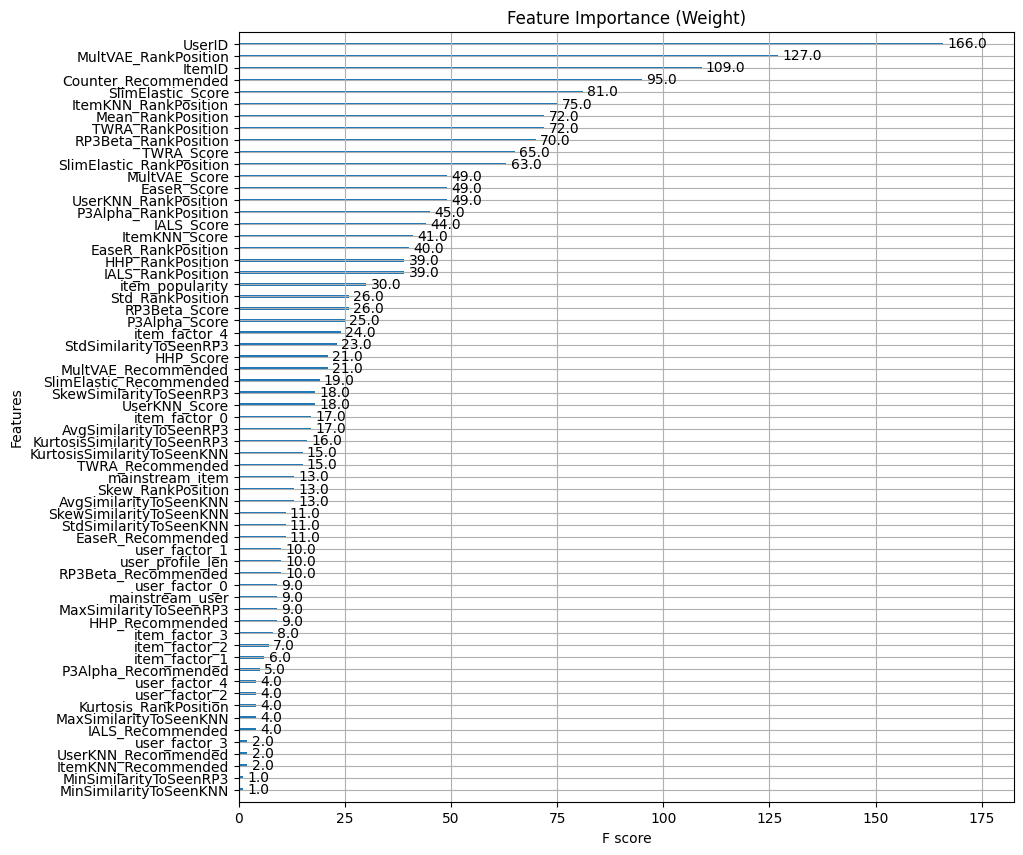

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='weight', title='Feature Importance (Weight)', ax=ax)

<Axes: title={'center': 'Feature Importance (Cover)'}, xlabel='F score', ylabel='Features'>

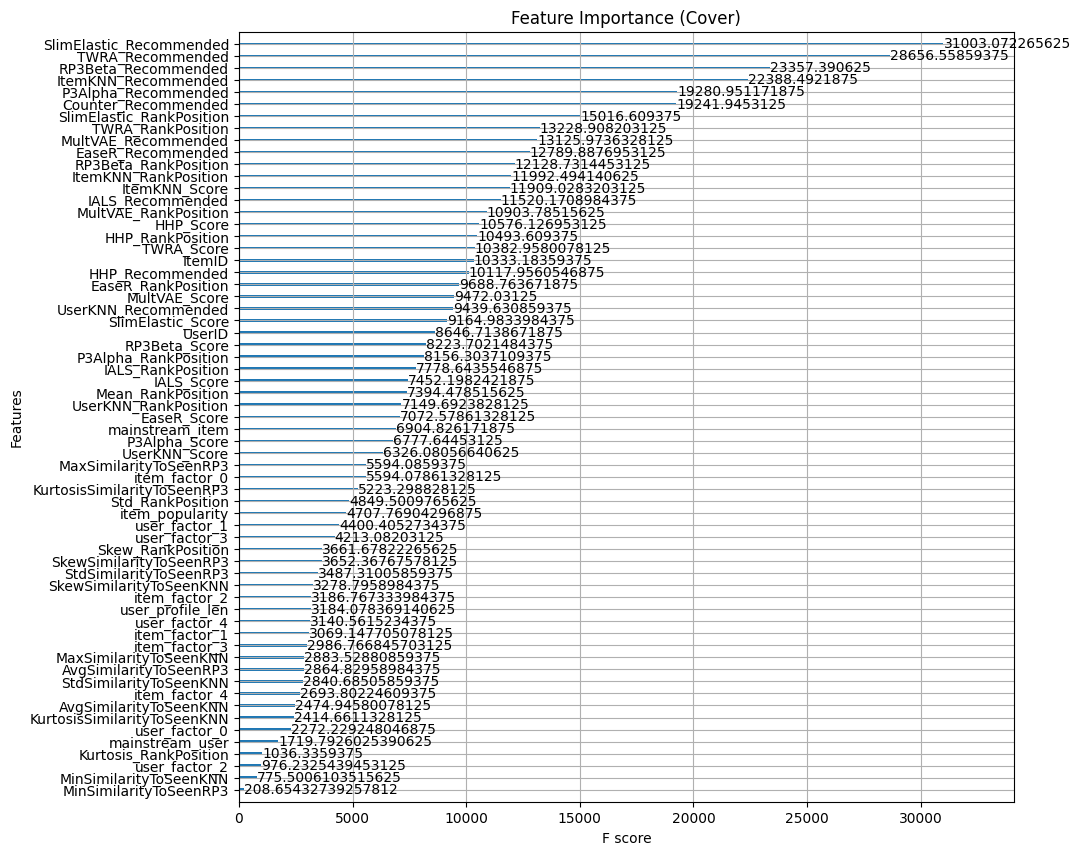

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='cover', title='Feature Importance (Cover)', ax=ax)

<Axes: title={'center': 'Feature Importance (Gain)'}, xlabel='F score', ylabel='Features'>

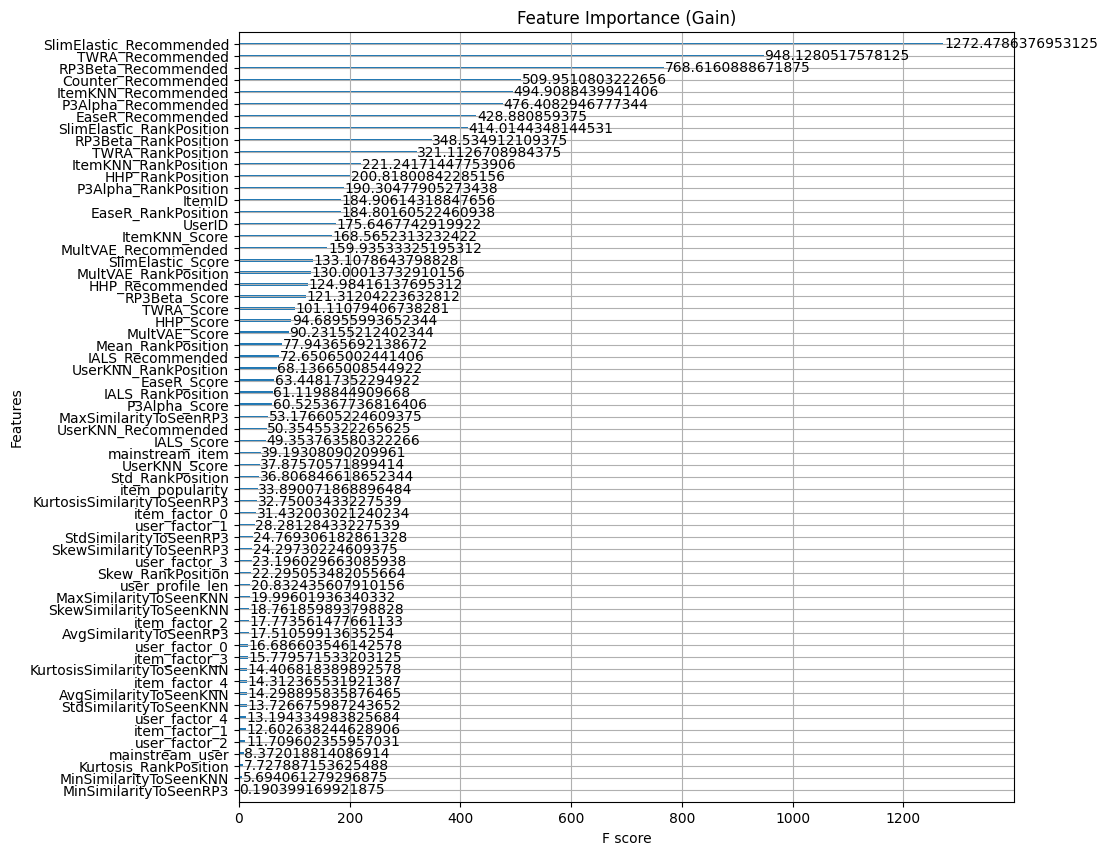

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(XGB_model, importance_type='gain', title='Feature Importance (Gain)', ax=ax)

In [73]:
recommender_item = ItemKNNCFRecommender(URM_all)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_all)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_all)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_all)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_all)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_pure_svd_item = PureSVDItemRecommender(URM_all)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_scaled_svd = ScaledPureSVDRecommender(URM_all)
recommender_scaled_svd.fit(**params_scaled)

recommender_nmf = NMFRecommender(URM_all)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_all.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_all)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_all.zip')

recommender_slim = SLIMElasticNetRecommender(URM_all)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_all.zip')

recommender_ease_r = EASE_R_Recommender(URM_all)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_all.zip')

recommender_ials = IALSRecommender(URM_all)
recommender_ials.load_model('/kaggle/working/', 'ials_all.zip')

recommender_vae = MultVAERecommender(URM_all)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_all')

recommender_hhp = HHPRecommender(URM_all)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_all)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_all)
# recommender_als.load_model('/kaggle/working/', 'als_all.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_all)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_all.zip')

recommender_rp3_recall = RP3betaRecommender(URM_all)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_all)
recommender_item_recall.fit(**params_item_knn_recall)

ItemKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22347 (100.0%), 910.09 column/sec. Elapsed time 24.55 sec
UserKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 13024 (100.0%), 601.94 column/sec. Elapsed time 21.64 sec
RP3betaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
RP3betaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2390.13 column/sec. Elapsed time 9.35 sec
P3alphaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
P3alphaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity colum

In [74]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
#     'NMF': recommender_nmf,
#     'PureSVD': recommender_pure_svd,
#     'ScaledSVD': recommender_scaled_svd,
#     'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
#     'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [75]:
cutoff = 50
n_users, n_items = URM_all.shape

prediction_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
prediction_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    prediction_dataframe.loc[user_id, "ItemID"] = recommendations
    
prediction_dataframe = prediction_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = prediction_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        prediction_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        prediction_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        prediction_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

prediction_dataframe = prediction_dataframe.reset_index()
prediction_dataframe = prediction_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in prediction_dataframe.columns if col.endswith('_Recommended')]
prediction_dataframe['Counter_Recommended'] = prediction_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in prediction_dataframe.columns if col.endswith('_RankPosition')]
prediction_dataframe['Mean_RankPosition'] = prediction_dataframe[position_columns].mean(axis=1)
prediction_dataframe['Std_RankPosition'] = prediction_dataframe[position_columns].std(axis=1)
prediction_dataframe['Skew_RankPosition'] = prediction_dataframe[position_columns].skew(axis=1)
prediction_dataframe['Kurtosis_RankPosition'] = prediction_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
item_popularity = item_popularity / np.max(item_popularity)
prediction_dataframe['item_popularity'] = item_popularity[prediction_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
user_popularity = user_popularity / np.max(user_popularity)
prediction_dataframe['user_profile_len'] = user_popularity[prediction_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_all.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
prediction_dataframe['mainstream_user'] = mainstream_user[prediction_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_all.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
prediction_dataframe['mainstream_item'] = mainstream_item[prediction_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

prediction_dataframe = prediction_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
prediction_dataframe = prediction_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
prediction_dataframe = prediction_dataframe.sort_values(by='UserID')

prediction_dataframe["UserID"] = prediction_dataframe["UserID"].astype(int)
prediction_dataframe["ItemID"] = prediction_dataframe["ItemID"].astype(int)
prediction_dataframe

/tmp/ipykernel_19/3716254121.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_19/3716254121.py:74: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/tmp/ipykernel_19/3716254121.py:75: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,0.000000,22150.0,0.0,0.056352,116.0,0.0,0.000000,22150.0,...,0.161283,0.057150,-0.179319,-0.017929,0.058489,0.005573,0.000276,0.007794,-0.010626,-0.001530
51,0,1067,0.000000,8334.0,0.0,0.062167,98.0,0.0,0.028730,174.0,...,0.006633,0.003640,0.012813,-0.006771,0.000972,0.005573,0.000276,0.007794,-0.010626,-0.001530
50,0,1056,0.148159,35.0,0.0,0.005110,4317.0,0.0,0.084663,23.0,...,0.002581,-0.001164,0.000103,-0.001671,0.001920,0.005573,0.000276,0.007794,-0.010626,-0.001530
49,0,976,0.166684,27.0,0.0,0.197222,5.0,1.0,0.044922,63.0,...,0.007626,-0.001412,0.009353,-0.007804,0.000635,0.005573,0.000276,0.007794,-0.010626,-0.001530
48,0,921,0.159207,31.0,0.0,0.120644,12.0,0.0,0.035512,102.0,...,0.008975,-0.001250,0.012296,-0.008343,0.003286,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060085,13023,440,0.000000,7151.0,0.0,0.384692,27.0,0.0,0.000000,7177.0,...,0.017581,-0.029270,0.021202,0.014549,0.051794,0.009693,-0.007923,-0.000422,0.004503,0.023066
1060081,13023,346,0.087640,62.0,0.0,0.520535,7.0,1.0,0.076672,60.0,...,0.024040,-0.046680,0.024238,0.026045,0.079139,0.009693,-0.007923,-0.000422,0.004503,0.023066
1060080,13023,334,0.299805,21.0,0.0,0.400558,25.0,0.0,0.067050,72.0,...,0.023503,-0.038707,0.037088,0.024652,0.048741,0.009693,-0.007923,-0.000422,0.004503,0.023066
1060106,13023,3608,0.436101,10.0,0.0,0.359568,31.0,0.0,0.314715,18.0,...,0.003459,-0.010568,0.004390,0.002426,0.012327,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [76]:
recommender = XGBoostRerankerRecommender(URM_all, XGB_model, prediction_dataframe)

In [77]:
recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10, return_scores=False)
recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
display(submission_df.head())

submission_df.to_csv('/kaggle/working/submission_xgboost_categorical.csv', index=False)

,user_id,item_list
0,1,101 36 403 123 515 694 506 1546 254 977
1,2,1095 47 12 1522 50 656 28 102 11 196
2,3,59 857 259 239 4252 536 956 584 1281 648
3,4,28 249 50 139 171 314 7 254 146 5
4,5,1570 77 131 5138 95 471 1220 170 1511 116
